In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import joblib
import os

In [2]:
df_final = pd.read_csv('../01_data/clean/df_final.csv')
df_final

,age,time_in_hospital,n_lab_procedures,primary_diagnosis,readmitted
0,(70-80),8,72,Circulatory,0
1,(70-80),3,34,Other,0
2,(50-60),5,45,Circulatory,1
3,(70-80),2,36,Circulatory,1
4,(60-70),1,42,Other,0
...,...,...,...,...,...
24995,(80-90),14,77,Circulatory,1
24996,(80-90),2,66,Digestive,1
24997,(70-80),5,12,Other,1
24998,(70-80),2,61,Respiratory,0


In [3]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   primary_diagnosis  25000 non-null  object
 4   readmitted         25000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 976.7+ KB


In [4]:
df_final.isnull().sum()

age                  0
time_in_hospital     0
n_lab_procedures     0
primary_diagnosis    0
readmitted           0
dtype: int64

In [5]:
df_final.dtypes

age                  object
time_in_hospital      int64
n_lab_procedures      int64
primary_diagnosis    object
readmitted            int64
dtype: object

Categorical and Numerical Variables (Encoding & Scaling)

In [6]:
df_final

,age,time_in_hospital,n_lab_procedures,primary_diagnosis,readmitted
0,(70-80),8,72,Circulatory,0
1,(70-80),3,34,Other,0
2,(50-60),5,45,Circulatory,1
3,(70-80),2,36,Circulatory,1
4,(60-70),1,42,Other,0
...,...,...,...,...,...
24995,(80-90),14,77,Circulatory,1
24996,(80-90),2,66,Digestive,1
24997,(70-80),5,12,Other,1
24998,(70-80),2,61,Respiratory,0


In [7]:
df_final['age'].value_counts()

age
(70-80)     6837
(60-70)     5913
(80-90)     4516
(50-60)     4452
(40-50)     2532
(90-100)     750
Name: count, dtype: int64

In [8]:
#Encoding age column
df_final['age'] = df_final['age'].str.strip().str.replace('(', '[').str.replace(')', ']')

# Check for any unique values in the 'age' column to verify the standardization
print("Unique age categories after cleaning:")
print(df_final['age'].unique())

# Define the ordered categories, ensure they match the cleaned 'age' column
age_categories = ['[20-30]', '[30-40]', '[40-50]', '[50-60]', '[60-70]', '[70-80]', '[80-90]', '[90-100]']

# Apply Ordinal Encoding based on the defined categories
ordinal_encoder = OrdinalEncoder(categories=[age_categories])

# Apply the encoding
df_final['age_encoded'] = ordinal_encoder.fit_transform(df_final[['age']])

# View the encoded result
print(df_final[['age', 'age_encoded']].head())


Unique age categories after cleaning:
['[70-80]' '[50-60]' '[60-70]' '[40-50]' '[80-90]' '[90-100]']
       age  age_encoded
0  [70-80]          5.0
1  [70-80]          5.0
2  [50-60]          3.0
3  [70-80]          5.0
4  [60-70]          4.0


In [9]:
df_final.dtypes

age                   object
time_in_hospital       int64
n_lab_procedures       int64
primary_diagnosis     object
readmitted             int64
age_encoded          float64
dtype: object

In [10]:
# One-hot encoding for 'primary_diagnosis' 
df_final = pd.get_dummies(df_final, columns=['primary_diagnosis'], drop_first=True)

In [11]:
df_final.columns


Index(['age', 'time_in_hospital', 'n_lab_procedures', 'readmitted',
       'age_encoded', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Digestive', 'primary_diagnosis_Injury',
       'primary_diagnosis_Missing', 'primary_diagnosis_Musculoskeletal',
       'primary_diagnosis_Other', 'primary_diagnosis_Respiratory'],
      dtype='object')

In [12]:
df_final

,age,time_in_hospital,n_lab_procedures,readmitted,age_encoded,primary_diagnosis_Diabetes,primary_diagnosis_Digestive,primary_diagnosis_Injury,primary_diagnosis_Missing,primary_diagnosis_Musculoskeletal,primary_diagnosis_Other,primary_diagnosis_Respiratory
0,[70-80],8,72,0,5.0,False,False,False,False,False,False,False
1,[70-80],3,34,0,5.0,False,False,False,False,False,True,False
2,[50-60],5,45,1,3.0,False,False,False,False,False,False,False
3,[70-80],2,36,1,5.0,False,False,False,False,False,False,False
4,[60-70],1,42,0,4.0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90],14,77,1,6.0,False,False,False,False,False,False,False
24996,[80-90],2,66,1,6.0,False,True,False,False,False,False,False
24997,[70-80],5,12,1,5.0,False,False,False,False,False,True,False
24998,[70-80],2,61,0,5.0,False,False,False,False,False,False,True


Perform Train Test Split

In [13]:
X = df_final.drop(columns=['readmitted', 'age'])  
y = df_final['readmitted'] 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler with pickle in the "scalers/" folder
scaler_path = "../05_scalers/scaler.pkl"
joblib.dump(scaler, scaler_path)

print(f"Scaler saved successfully to {scaler_path}")

Scaler saved successfully to ../05_scalers/scaler.pkl


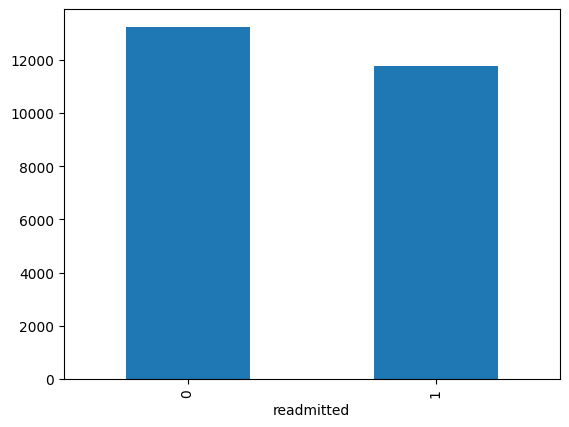

In [16]:
target_column = 'readmitted'  
target_distribution = df_final["readmitted"].value_counts()
target_distribution.plot(kind="bar")
plt.show()

Logistic Regression Model - Used this becasue my target variable has binary classification

In [17]:
log_reg = LogisticRegression()
base_model_lr = log_reg.fit(X_train_scaled, y_train)


In [18]:
log_reg.score(X_test_scaled, y_test)

0.5214

In [19]:
pred = log_reg.predict(X_test_scaled)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.52      0.83      0.64      2566
           1       0.52      0.20      0.28      2434

    accuracy                           0.52      5000
   macro avg       0.52      0.51      0.46      5000
weighted avg       0.52      0.52      0.47      5000



In [20]:
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5214
Confusion Matrix:
 [[2132  434]
 [1959  475]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.83      0.64      2566
           1       0.52      0.20      0.28      2434

    accuracy                           0.52      5000
   macro avg       0.52      0.51      0.46      5000
weighted avg       0.52      0.52      0.47      5000



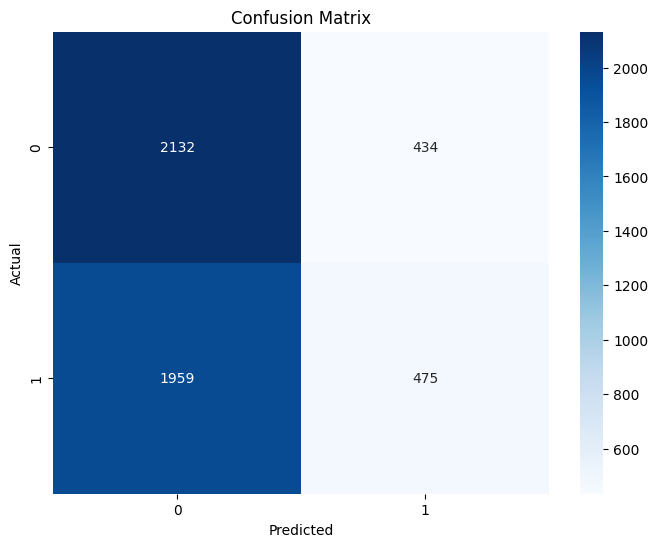

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SMOTE to Correct Imbalance

In [22]:
smote = SMOTE(random_state = 1,sampling_strategy=1.0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Testing the Logistic Regression Model after SMOTE

In [23]:
log_reg = LogisticRegression()
log_resampled = log_reg.fit(X_train_resampled, y_train_resampled)


In [24]:
log_reg.score(X_test_scaled, y_test)

C:\Users\Nicole\Ironhack\Bootcamp\Final_Project\Hospital-Readmission-Insights\.venv_final\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.5238

In [25]:
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5238
Confusion Matrix:
 [[2422  144]
 [2237  197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.94      0.67      2566
           1       0.58      0.08      0.14      2434

    accuracy                           0.52      5000
   macro avg       0.55      0.51      0.41      5000
weighted avg       0.55      0.52      0.41      5000



C:\Users\Nicole\Ironhack\Bootcamp\Final_Project\Hospital-Readmission-Insights\.venv_final\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Trying Random Forest

In [26]:
# Train a classifier
clf = RandomForestClassifier()
base_model_rf = clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.97      0.67      2566
           1       0.45      0.03      0.05      2434

    accuracy                           0.51      5000
   macro avg       0.48      0.50      0.36      5000
weighted avg       0.48      0.51      0.37      5000

[[2490   76]
 [2372   62]]


C:\Users\Nicole\Ironhack\Bootcamp\Final_Project\Hospital-Readmission-Insights\.venv_final\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Testing after SMOTE

In [27]:
# Train a classifier
clf = RandomForestClassifier()
ref_resampled = clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.53      0.56      0.54      2566
           1       0.50      0.47      0.49      2434

    accuracy                           0.52      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.52      0.52      0.52      5000

[[1426 1140]
 [1281 1153]]


Trying Gradient Boosting

Normalizer using MinMaxScaler

In [28]:
# Fit the scaler on the training data and transform both the training and testing data
scaler_mm = MinMaxScaler()
X_train_scaled_mm = scaler_mm.fit_transform(X_train)
X_test_scaled_mm = scaler_mm.transform(X_test)


Fine tuning using decisiontreeclassifier using random search

In [29]:
grid = {"max_leaf_nodes": [int(x) for x in np.linspace(start = 5, stop = 30, num = 3)],
        "max_depth":[int(x) for x in np.linspace(1, 11, num = 3)]}

In [30]:
dt = DecisionTreeClassifier()

In [31]:
# n_iter specifies how many possible randomly selected combinations of hyper-parameters will be used.
model = RandomizedSearchCV(estimator = dt, param_distributions = grid, n_iter = 5, cv = 5)

In [32]:
model.fit(X_train_scaled_mm,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'max_depth': [1, 6, 11],
                                        'max_leaf_nodes': [5, 17, 30]})

In [33]:
model.best_params_

{'max_leaf_nodes': 5, 'max_depth': 11}

In [34]:
best_model = model.best_estimator_

In [35]:
pred = best_model.predict(X_test_scaled_mm)

print(f"MAE: {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE: {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score:  {best_model.score(X_test_scaled_mm, y_test): .2f}")

MAE:  0.49
RMSE:  0.70
R2 score:   0.51


C:\Users\Nicole\Ironhack\Bootcamp\Final_Project\Hospital-Readmission-Insights\.venv_final\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


INTEPRETATION: predictive performance is moderate at best. 
The MAE and RMSE - average error, but the R² score shows that the model does not account for more than half of the variability in the data.

DecisionTreeClassifier with RandimizationSearchCV

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
model = DecisionTreeClassifier()

# Define the parameter distributions
param_distributions = {
    'max_depth': [1, 6, 11],         # Valid parameter
    'max_leaf_nodes': [5, 17, 30],   # Valid parameter
    'min_samples_split': [2, 5, 10],  # Additional valid parameter
    'min_samples_leaf': [1, 2, 4]     # Additional valid parameter
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   n_iter=5,
                                   cv=5,
                                   scoring='accuracy',  # or 'neg_mean_squared_error' for regression
                                   random_state=42)

# Fit the model
random_search.fit(X_train_scaled_mm, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'max_depth': [1, 6, 11],
                                        'max_leaf_nodes': [5, 17, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [37]:
# Best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 5, 'max_depth': 6}


In [38]:
# Retrain the model with the best parameters
best_model = DecisionTreeClassifier(
    min_samples_split=2,
    min_samples_leaf=2,
    max_leaf_nodes=5,
    max_depth=6
)

# Fit the model
best_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.97      0.67      2566
           1       0.43      0.02      0.05      2434

    accuracy                           0.51      5000
   macro avg       0.47      0.50      0.36      5000
weighted avg       0.47      0.51      0.37      5000



In [39]:
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                    index=X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                                   importance
time_in_hospital                     0.663222
n_lab_procedures                     0.169282
age_encoded                          0.167496
primary_diagnosis_Diabetes           0.000000
primary_diagnosis_Digestive          0.000000
primary_diagnosis_Injury             0.000000
primary_diagnosis_Missing            0.000000
primary_diagnosis_Musculoskeletal    0.000000
primary_diagnosis_Other              0.000000
primary_diagnosis_Respiratory        0.000000


In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", np.mean(scores))


Cross-validation scores: [0.5355  0.53325 0.53225 0.533   0.5365 ]
Mean CV score: 0.5340999999999999


INTEPRETATION
Stability: The scores are quite close to each other, indicating that your model performs consistently across different subsets of your data. This is a good sign, as it suggests that your model is not overly sensitive to the specific data it is trained on and is likely to generalize well to new, unseen data.
Performance Level: A mean CV score of 0.5341 indicates that your model's performance is about 53.41%.
Accuracy, it means the model correctly classifies about 53.41% of instances in general.

Summary of Feature Importance
Key Predictors:

1) Time in Hospital:
Importance: 66.32%
Most significant predictor of readmission likelihood.

2) Number of Lab Procedures:
Importance: 16.93%
Reflects severity or complexity of health issues.

3) Age Encoded:
Importance: 16.75%
Important for understanding readmission risks associated with age.

4) Primary Diagnosis Features:
All primary diagnosis features (Diabetes, Digestive, Injury, etc.):
Importance: 0.00%
Do not contribute to model predictions, suggesting limited relevance in this context.

Potential Improvements:
Explore different representations or interactions of primary diagnosis features.
Consider adding more relevant features to enhance predictive power.

Focus Areas:
Emphasize the importance of time in hospital and lab procedures when evaluating readmission risks.
Reassess how diagnosis data is utilized in the model.

SMOTE to tackle the class imbalance

In [41]:
smote = SMOTE(random_state = 1,sampling_strategy=1.0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled_mm, y_train)

Fine tuning after SMOTE - random search - DecisionTreeClassifier with RandomizedSearchCV

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
model = DecisionTreeClassifier()

# Define the parameter distributions
param_distributions = {
    'max_depth': [1, 6, 11],         # Valid parameter
    'max_leaf_nodes': [5, 17, 30],   # Valid parameter
    'min_samples_split': [2, 5, 10],  # Additional valid parameter
    'min_samples_leaf': [1, 2, 4]     # Additional valid parameter
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   n_iter=5,
                                   cv=5,
                                   scoring='accuracy',  # or 'neg_mean_squared_error' for regression
                                   random_state=42)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'max_depth': [1, 6, 11],
                                        'max_leaf_nodes': [5, 17, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='accuracy')

In [43]:
# Best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 5, 'max_depth': 6}


In [44]:
# Retrain the model with the best parameters
best_model = DecisionTreeClassifier(
    min_samples_split=2,
    min_samples_leaf=2,
    max_leaf_nodes=5,
    max_depth=6
)

# Fit the model
best_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
y_pred = best_model.predict(X_test_scaled_mm)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2566
           1       0.50      0.78      0.61      2434

    accuracy                           0.52      5000
   macro avg       0.53      0.52      0.49      5000
weighted avg       0.53      0.52      0.48      5000



In [45]:
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                    index=X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                                   importance
time_in_hospital                     0.669363
age_encoded                          0.182725
n_lab_procedures                     0.147912
primary_diagnosis_Diabetes           0.000000
primary_diagnosis_Digestive          0.000000
primary_diagnosis_Injury             0.000000
primary_diagnosis_Missing            0.000000
primary_diagnosis_Musculoskeletal    0.000000
primary_diagnosis_Other              0.000000
primary_diagnosis_Respiratory        0.000000


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", np.mean(scores))


Cross-validation scores: [0.52013109 0.50561798 0.51451311 0.52457865 0.52832397]
Mean CV score: 0.5186329588014982


INTEPRETATION
The model has higher recall for class 1 (0.78) but struggles with recall for class 0 (0.27), indicating that the model often misses classifying true class 0 instances.
The F1 score is better for class 1 (0.61) compared to class 0 (0.36), which means the model is more effective in predicting class 1.
The overall accuracy is 52%, which suggests that the model is only slightly better than random guessing for a binary classification task.

Random Forest Classifier using Grid Search and MinMax Scaler Data

In [47]:
grid = {"max_leaf_nodes": [250, 500, 1000],
        "max_depth":[10,30,50]}

In [48]:
dt = RandomForestClassifier()

In [49]:
model = GridSearchCV(estimator = dt, param_grid = grid, cv=5, verbose=10)

In [50]:
model.fit(X_train_scaled_mm, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=10, max_leaf_nodes=250............................
[CV 1/5; 1/9] END max_depth=10, max_leaf_nodes=250;, score=0.535 total time=   0.8s
[CV 2/5; 1/9] START max_depth=10, max_leaf_nodes=250............................
[CV 2/5; 1/9] END max_depth=10, max_leaf_nodes=250;, score=0.535 total time=   0.8s
[CV 3/5; 1/9] START max_depth=10, max_leaf_nodes=250............................
[CV 3/5; 1/9] END max_depth=10, max_leaf_nodes=250;, score=0.538 total time=   0.8s
[CV 4/5; 1/9] START max_depth=10, max_leaf_nodes=250............................
[CV 4/5; 1/9] END max_depth=10, max_leaf_nodes=250;, score=0.532 total time=   0.8s
[CV 5/5; 1/9] START max_depth=10, max_leaf_nodes=250............................
[CV 5/5; 1/9] END max_depth=10, max_leaf_nodes=250;, score=0.539 total time=   0.8s
[CV 1/5; 2/9] START max_depth=10, max_leaf_nodes=500............................
[CV 1/5; 2/9] END max_depth=10, ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 30, 50],
                         'max_leaf_nodes': [250, 500, 1000]},
             verbose=10)

In [51]:
model.best_params_

{'max_depth': 50, 'max_leaf_nodes': 250}

In [52]:
best_model = model.best_estimator_

In [53]:
pred = best_model.predict(X_test_scaled_mm)

print(f"MAE: {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE: {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score:  {best_model.score(X_test_scaled_mm, y_test): .2f}")

MAE:  0.47
RMSE:  0.69
R2 score:   0.53


C:\Users\Nicole\Ironhack\Bootcamp\Final_Project\Hospital-Readmission-Insights\.venv_final\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [54]:
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                    index=X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

                                   importance
n_lab_procedures                     0.498347
time_in_hospital                     0.246833
age_encoded                          0.151650
primary_diagnosis_Musculoskeletal    0.020529
primary_diagnosis_Diabetes           0.020021
primary_diagnosis_Other              0.019708
primary_diagnosis_Respiratory        0.015516
primary_diagnosis_Injury             0.014487
primary_diagnosis_Digestive          0.011842
primary_diagnosis_Missing            0.001066


In [55]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train_scaled_mm, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", np.mean(scores))


Cross-validation scores: [0.53925 0.54025 0.5425  0.534   0.543  ]
Mean CV score: 0.5398


INTERPRETATION
MAE:  0.48 - on average, the model's predictions are off by 0.48 units. 
RMSE:  0.69 - 
R2 score:   0.52 - 52% of the variance is explained by the model, which suggests that the model captures a reasonable amount of information, but there’s still room for improvement.

Feature Importance:
The feature importances indicate how much each feature contributes to the model's predictions. Here’s a breakdown of the key features:

	1. n_lab_procedures (0.4958): This feature is by far the most important, contributing nearly 50% to the model's decisions. It suggests that the number of lab procedures is a crucial predictor for the target variable
	2. time_in_hospital (0.2509): The second most important feature, time spent in the hospital, accounts for about 25% of the prediction power. Together with lab procedures, these two features dominate the mode.
	3. age_encoded (0.1566): Age contributes about 15.6%, making it the third most important factor, but less significant than lab procedures or time in the hospitl.
	4. primary_diagnosis_*: These features represent various diagnostic categories (like diabetes, respiratory issues, musculoskeletal, etc.) but contribute much less, ranging between 1-2%. This implies that diagnosis, while relevant, is much less important than the other featu
Cross-validation Scores:

The model shows stable performance across the cross-validation folds, indicating reliable generalization to unseen data, with an average score of 0.5367.
Overall Interpretation:
	• The model explains around 52% of the variance (R² score), indicating it has a decent predictive capability, although there is room for improvement.
	• The key drivers of the model are n_lab_procedures, time_in_hospital, and age_encoded, with lab procedures being the dominant feature.
	• Diagnosis type appears to have relatively low importance compared to the other features.
	• The model shows stable performance across the cross-validation folds, indicating reliable generalization to unseen data, with an average score of 0.567.

res.


--------------- 1st October ------------

In [56]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Fit the scaler on the training data and transform both the training and testing data
scaler_mm = MinMaxScaler()
X_train_scaled_mm = scaler_mm.fit_transform(X_train)
X_test_scaled_mm = scaler_mm.transform(X_test)

# Define a function to calculate metrics for each model
def calculate_metrics(model, X_train, y_train, X_test, y_test):
    # Train predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # For binary classification, predict_proba can be used for AUC-ROC
    if hasattr(model, 'predict_proba'):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        # In case the model does not support predict_proba, fallback to binary predictions
        y_train_prob = y_train_pred
        y_test_prob = y_test_pred
    
    return {
        'Train accuracy': accuracy_score(y_train, y_train_pred),
        'Test accuracy': accuracy_score(y_test, y_test_pred),
        'Train_f1': f1_score(y_train, y_train_pred),
        'Test_f1': f1_score(y_test, y_test_pred),
        'Train_precision': precision_score(y_train, y_train_pred),
        'Test_precision': precision_score(y_test, y_test_pred),
        'Train_recall': recall_score(y_train, y_train_pred),
        'Test_recall': recall_score(y_test, y_test_pred),
        'Train_auc_roc': roc_auc_score(y_train, y_train_prob),
        'Test_auc_roc': roc_auc_score(y_test, y_test_prob)
    }

# Define a function to calculate cross-validation score
def calculate_cross_val_score(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Using accuracy for simplicity
    return np.mean(cv_scores)

# Create an empty list to store the model performance metrics
metrics_data = []



In [57]:
# Logistic Regression
log_reg = LogisticRegression()
base_model_lr_mm = log_reg.fit(X_train_scaled_mm, y_train)
lr_metrics = calculate_metrics(log_reg, X_train_scaled_mm, y_train, X_test_scaled_mm, y_test)
lr_metrics['Model'] = 'Logistic Regression Base'
lr_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(log_reg, X_train_scaled_mm, y_train)
metrics_data.append(lr_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(base_model_lr_mm, os.path.join(models_path, 'base_model_lr_mm.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.5327,0.521,0.281519,0.283149,0.496475,0.521499,0.196459,0.19433,0.54573,0.546575,0.53205


In [58]:
# Logistic Regression with BALANCED SETS using SMOTE
log_reg = LogisticRegression()
resampled_lr = log_reg.fit(X_train_resampled, y_train_resampled)
lr_metrics = calculate_metrics(log_reg, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
lr_metrics['Model'] = 'Logistic Regression Balanced'
lr_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(log_reg, X_train_resampled, y_train_resampled)
metrics_data.append(lr_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(resampled_lr , os.path.join(models_path, 'resampled_lr.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831


In [59]:
# Random Forest Classifier
clf = RandomForestClassifier()
base_model_rf_mm = clf.fit(X_train_scaled_mm, y_train)
rf_metrics = calculate_metrics(clf, X_train_scaled_mm, y_train, X_test_scaled_mm, y_test)
rf_metrics['Model'] = 'Random Forest Base'
rf_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(clf, X_train_scaled_mm, y_train)
metrics_data.append(rf_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(base_model_rf_mm, os.path.join(models_path, 'base_model_rf_mm.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350


In [60]:
# Random Forest Classifier wit BALANCED SETS using SMOTE
clf = RandomForestClassifier()
resampled_rf = clf.fit(X_train_resampled, y_train_resampled)
rf_metrics = calculate_metrics(clf, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
rf_metrics['Model'] = 'Random Forest Balanced'
rf_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(clf, X_train_resampled, y_train_resampled)
metrics_data.append(rf_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(resampled_rf , os.path.join(models_path, 'resampled_rf.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189


In [61]:
#Hyperparameter Tuning for Random Forest Balanced to adjust for overfitting of the train set
param_grid_rf = {
    'n_estimators': [50, 100, 150],        # Reasonable range of estimators
    'max_depth': [10, 20, None],           # Depth up to 20 or None for unpruned trees
    'min_samples_split': [2, 5],           # Reasonable for controlling overfitting
    'min_samples_leaf': [1, 2],            # Leaf size tuning to reduce overfitting
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=1)

# Perform GridSearchCV with cv=5 and n_jobs=2 for parallelization. scorer = make_scorer(recall_Score, higher_is_better=True)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=2, verbose=2)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters: ", grid_search_rf.best_params_)

# Evaluate on test set
rf_metrics = calculate_metrics(best_rf, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
rf_metrics['Model'] = 'Random Forest Tuned'
rf_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(best_rf, X_train_resampled, y_train_resampled)
metrics_data.append(rf_metrics)

# Convert the metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the decision tree model using joblib
models_path = "../06_models"
joblib.dump(best_rf, os.path.join(models_path, 'tuned_rf.pkl'))

# Display the DataFrame with metrics
display(df_metrics)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509


In [62]:
# Gradient Boosting Classifier 
gb = GradientBoostingClassifier(max_depth=20, n_estimators=100)
base_model_gb_mm = gb.fit(X_train_scaled_mm, y_train)
gb_metrics = calculate_metrics(gb, X_train_scaled_mm, y_train, X_test_scaled_mm, y_test)
gb_metrics['Model'] = 'Gradient Boosting Base'
gb_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(gb, X_train_scaled_mm, y_train)
metrics_data.append(gb_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(base_model_gb_mm, os.path.join(models_path, 'base_model_gb_mm.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550


In [63]:
# Gradient Boosting Classifier wit BALANCED SETS using SMOTE
gb = GradientBoostingClassifier(max_depth=20, n_estimators=100)
resampled_gb = gb.fit(X_train_resampled, y_train_resampled)
gb_metrics = calculate_metrics(gb, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
gb_metrics['Model'] = 'Gradient Boosting Balanced'
gb_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(gb, X_train_resampled, y_train_resampled)
metrics_data.append(gb_metrics)

# Convert metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the models
models_path = "../06_models"
joblib.dump(resampled_gb, os.path.join(models_path, 'resampled_gb.pkl'))

# Display the DataFrame
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550
6,Gradient Boosting Balanced,0.831835,0.5220,0.830406,0.490405,0.837524,0.509752,0.823408,0.472473,0.936673,0.526087,0.532397


In [64]:
#Hyperparameter Tuning for Gradient Boosting Balanced to adjust for overfitting
param_grid_gb = {
    'n_estimators': [50, 100],             # Lower number of trees
    'learning_rate': [0.01, 0.1],          # Common learning rates
    'max_depth': [3, 5],                   # Shallower trees are often better for GBM
    'min_samples_split': [2, 5]            # Reasonable split sizes
}

# Initialize GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=1)

# Perform GridSearchCV with cv=5 and n_jobs=2 for parallelization
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='f1', n_jobs=2, verbose=2)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
best_gb = grid_search_gb.best_estimator_
print("Best Gradient Boosting Parameters: ", grid_search_gb.best_params_)

# Evaluate on test set
gb_metrics = calculate_metrics(best_gb, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
gb_metrics['Model'] = 'Gradient Boosting Tuned'
gb_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(best_gb, X_train_resampled, y_train_resampled)
metrics_data.append(gb_metrics)

# Convert the metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the decision tree model using joblib
models_path = "../06_models"
joblib.dump(best_gb, os.path.join(models_path, 'tuned_gb.pkl'))

# Display the DataFrame with metrics
display(df_metrics)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Gradient Boosting Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550
6,Gradient Boosting Balanced,0.831835,0.5220,0.830406,0.490405,0.837524,0.509752,0.823408,0.472473,0.936673,0.526087,0.532397
7,Gradient Boosting Tuned,0.539279,0.5328,0.616888,0.597935,0.527954,0.514514,0.741854,0.713640,0.552905,0.554256,0.524532


In [65]:
# Decision Tree Classifier 
dt = DecisionTreeClassifier(max_depth=20, random_state=1)  
base_model_dt_mm = dt.fit(X_train_scaled_mm, y_train)
dt_metrics = calculate_metrics(dt, X_train_scaled_mm, y_train, X_test_scaled_mm, y_test)
dt_metrics['Model'] = 'Decision Tree Base'
dt_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(dt, X_train_scaled_mm, y_train)
metrics_data.append(dt_metrics)

# Convert the metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the decision tree model using joblib
models_path = "../06_models"
joblib.dump(base_model_dt_mm, os.path.join(models_path, 'base_model_dt_mm.pkl'))

# Display the DataFrame with metrics
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550
6,Gradient Boosting Balanced,0.831835,0.5220,0.830406,0.490405,0.837524,0.509752,0.823408,0.472473,0.936673,0.526087,0.532397
7,Gradient Boosting Tuned,0.539279,0.5328,0.616888,0.597935,0.527954,0.514514,0.741854,0.713640,0.552905,0.554256,0.524532
8,Decision Tree Base,0.755350,0.5172,0.721117,0.464982,0.769119,0.504812,0.678755,0.430978,0.864070,0.522467,0.517650


In [66]:
# Decision Tree Classifier with BALANCED SETS using SMOTE
dt = DecisionTreeClassifier(max_depth=20, random_state=1)  # Adjust hyperparameters if necessary
resampled_dt = dt.fit(X_train_resampled, y_train_resampled)
dt_metrics = calculate_metrics(dt, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
dt_metrics['Model'] = 'Decision Tree Balanced'
dt_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(dt, X_train_resampled, y_train_resampled)
metrics_data.append(dt_metrics)

# Convert the metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the decision tree model using joblib
models_path = "../06_models"
joblib.dump(resampled_dt, os.path.join(models_path, 'resampled_dt.pkl'))

# Display the DataFrame with metrics
display(df_metrics)

,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550
6,Gradient Boosting Balanced,0.831835,0.5220,0.830406,0.490405,0.837524,0.509752,0.823408,0.472473,0.936673,0.526087,0.532397
7,Gradient Boosting Tuned,0.539279,0.5328,0.616888,0.597935,0.527954,0.514514,0.741854,0.713640,0.552905,0.554256,0.524532
8,Decision Tree Base,0.755350,0.5172,0.721117,0.464982,0.769119,0.504812,0.678755,0.430978,0.864070,0.522467,0.517650
9,Decision Tree Balanced,0.708708,0.5230,0.720158,0.516325,0.692920,0.509812,0.749625,0.523007,0.815408,0.526610,0.529682


In [67]:
#Hyperparameter Tuning for Decision Tree Balanced 
param_grid_dt = {
    'max_depth': [10, 20, None],           # Reasonable depth
    'min_samples_split': [2, 5],           # Standard splits
    'min_samples_leaf': [1, 2]             # Regular leaf sizes
}

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)

# Perform GridSearchCV with cv=5 and n_jobs=2 for parallelization
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='f1', n_jobs=2, verbose=2)
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
best_dt = grid_search_dt.best_estimator_
print("Best Decision Tree Parameters: ", grid_search_dt.best_params_)

# Evaluate on test set
dt_metrics = calculate_metrics(best_dt, X_train_resampled, y_train_resampled, X_test_scaled_mm, y_test)
dt_metrics['Model'] = 'Decision Tree Tuned'
dt_metrics['Avg Cross-Val Score'] = calculate_cross_val_score(best_dt, X_train_resampled, y_train_resampled)
metrics_data.append(dt_metrics)

# Convert the metrics data into a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=[
    'Model', 'Train accuracy', 'Test accuracy', 'Train_f1', 'Test_f1',
    'Train_precision', 'Test_precision', 'Train_recall', 'Test_recall',
    'Train_auc_roc', 'Test_auc_roc', 'Avg Cross-Val Score'
])

# Save the decision tree model using joblib
models_path = "../06_models"
joblib.dump(best_dt, os.path.join(models_path, 'tuned_dt.pkl'))

# Display the DataFrame with metrics
display(df_metrics)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Decision Tree Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


,Model,Train accuracy,Test accuracy,Train_f1,Test_f1,Train_precision,Test_precision,Train_recall,Test_recall,Train_auc_roc,Test_auc_roc,Avg Cross-Val Score
0,Logistic Regression Base,0.532700,0.5210,0.281519,0.283149,0.496475,0.521499,0.196459,0.194330,0.545730,0.546575,0.532050
1,Logistic Regression Balanced,0.535815,0.5332,0.535227,0.517968,0.535905,0.520764,0.534551,0.515201,0.546482,0.546989,0.534831
2,Random Forest Base,0.821950,0.5148,0.805484,0.475346,0.820407,0.501826,0.791094,0.451520,0.921341,0.522658,0.519350
3,Random Forest Balanced,0.831835,0.5130,0.831012,0.478921,0.835098,0.499777,0.826966,0.459737,0.929181,0.522041,0.536189
4,Random Forest Tuned,0.630337,0.5292,0.671274,0.564558,0.604348,0.513459,0.754869,0.626952,0.698227,0.548946,0.542509
5,Gradient Boosting Base,0.821950,0.5182,0.804823,0.482047,0.822633,0.505638,0.787768,0.460559,0.928814,0.523636,0.515550
6,Gradient Boosting Balanced,0.831835,0.5220,0.830406,0.490405,0.837524,0.509752,0.823408,0.472473,0.936673,0.526087,0.532397
7,Gradient Boosting Tuned,0.539279,0.5328,0.616888,0.597935,0.527954,0.514514,0.741854,0.713640,0.552905,0.554256,0.524532
8,Decision Tree Base,0.755350,0.5172,0.721117,0.464982,0.769119,0.504812,0.678755,0.430978,0.864070,0.522467,0.517650
9,Decision Tree Balanced,0.708708,0.5230,0.720158,0.516325,0.692920,0.509812,0.749625,0.523007,0.815408,0.526610,0.529682


In [68]:
#saving the model df_metric as a .csv file
df_metrics.to_csv('../01_data/clean/df_metrics.csv', index=False)